In [115]:
"""
read in the MVPA data
bring it into the right shape to feed it into the CNN

first do it with one MVPA component
then do it with all MVPA components by concatenating them into a dense layer


"""

'\nread in the MVPA data\nbring it into the right shape to feed it into the CNN\n\nfirst do it with one MVPA component\nthen do it with all MVPA components by concatenating them into a dense layer\n\n\n'

In [139]:
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [134]:
# read in the excel-file with the labels
label_path = "X:/MasterThesis_Reto"
label_file = "Conn_IDs_Matching.xlsx"
# read excel with only the first three columns
label_df = (pd.read_excel(os.path.join(label_path, label_file),
                            usecols=[0, 1, 2])
            .replace({"Cond": {1: 0}})
            .replace({"Cond": {2: 1}})
            )

label_df[-5:]

,Conn_SubjNr,VPNr,Cond
63,64,80,0
64,65,83,0
65,66,86,1
66,67,87,1
67,68,88,0


In [117]:
# read MVPA data
file_path = "X:/MasterThesis_Reto/Denoised_Data_6mm"
path_content = os.listdir(os.path.join(file_path, "MVPA_data"))

# make two lists with pre (Condition002) and post (Condition003) data of first component
comp1_pre = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition002" in x])
comp1_post = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition003" in x])

print(comp1_pre[:5])

['BETA_Subject001_Condition002_Measure002_Component001.nii', 'BETA_Subject002_Condition002_Measure002_Component001.nii', 'BETA_Subject003_Condition002_Measure002_Component001.nii', 'BETA_Subject004_Condition002_Measure002_Component001.nii', 'BETA_Subject005_Condition002_Measure002_Component001.nii']


In [118]:
# create a dataset with the difference of pre and post data
comp1_diff = []
for pre, post in zip(comp1_pre, comp1_post):
    pre_vol = nib.load(os.path.join(file_path, "MVPA_data", pre))
    post_vol = nib.load(os.path.join(file_path, "MVPA_data", post))
    pre_vol_data = pre_vol.get_fdata()
    post_vol_data = post_vol.get_fdata()
    diff_vol_data = post_vol_data - pre_vol_data
    comp1_diff.append(diff_vol_data)

# check the shape of the data
print(comp1_diff[0].shape)

# check the type of the data
print(type(comp1_diff[0]))

# takes about 3-4 mins to run on Dell

(91, 109, 91)
<class 'numpy.ndarray'>


In [175]:
# stack the data to later use it as input for the CNN
# note: the first dimension is the number of samples
print(f"shape of one list element before stacking: {comp1_diff[0].shape=}")
inpt_comp1_diff = np.stack(comp1_diff, axis=0)

# expand the dimensions to fit the input shape of the CNN
# note: the last dimension is the number of channels
inpt_comp1_diff = np.expand_dims(inpt_comp1_diff, axis=-1)

# normalize the input data (zero mean, unit variance)
# note: a CNN works best with normalized data
inpt_comp1_diff = (inpt_comp1_diff - inpt_comp1_diff.mean()) / inpt_comp1_diff.std()

print(f"{inpt_comp1_diff.shape=}",
      f"{inpt_comp1_diff.mean()=}",
      f"{inpt_comp1_diff.std()=}", sep="\n")

shape of one list element before stacking: comp1_diff[0].shape=(91, 109, 91)
inpt_comp1_diff.shape=(68, 91, 109, 91, 1)
inpt_comp1_diff.mean()=1.2019033790773762e-16
inpt_comp1_diff.std()=0.9999999999999889


In [153]:
# split the data into training and test data
# use 80% of the data for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(inpt_comp1_diff, 
                                                    label_df["Cond"], 
                                                    test_size=0.2, 
                                                    random_state=42)

# TODO: use cross-validation to get a better estimate of the model performance

# TODO: eventually add more regularization to the model (batch normalization)

# TODO: save the best model and load it again to make predictions on the test data

# TODO: do I only need to normalize the test data? 
#       Or only take the mean and std of the training data and apply it to all data?

In [169]:
# built a keras CNN model with functional API
inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
x = layers.Conv3D(8, 3, activation="relu")(inputs)
x = layers.MaxPooling3D(3)(x)
x = layers.Conv3D(16, 3, activation="relu")(x)
x = layers.MaxPooling3D(3)(x)
x = layers.Conv3D(32, 3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# define the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 91, 109, 91, 1)]  0         
                                                                 
 conv3d_88 (Conv3D)          (None, 89, 107, 89, 8)    224       
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 29, 35, 29, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 27, 33, 27, 16)    3472      
                                                                 
 max_pooling3d_57 (MaxPoolin  (None, 9, 11, 9, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_90 (Conv3D)          (None, 7, 9, 7, 32)       138

In [167]:
# built a keras CNN model with functional API
inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
x = layers.Conv3D(filters=8, kernel_size=3, 
                    # kernel_regularizer=regularizers.l2(0.002),
                    activation="relu")(inputs)
x = layers.MaxPooling3D(pool_size=3, 
                        strides=3, 
                        padding='valid')(x)
x = layers.Conv3D(filters=16, kernel_size=3, 
                    # kernel_regularizer=regularizers.l2(0.002), 
                    activation="relu")(x)
x = layers.MaxPooling3D(pool_size=3, 
                        strides=3, 
                        padding='valid')(x)
x = layers.Conv3D(filters=32, kernel_size=3, 
                    # kernel_regularizer=regularizers.l2(0.002), 
                    activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# define the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 91, 109, 91, 1)]  0         
                                                                 
 conv3d_85 (Conv3D)          (None, 89, 107, 89, 8)    224       
                                                                 
 max_pooling3d_54 (MaxPoolin  (None, 29, 35, 29, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_86 (Conv3D)          (None, 27, 33, 27, 16)    3472      
                                                                 
 max_pooling3d_55 (MaxPoolin  (None, 9, 11, 9, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_87 (Conv3D)          (None, 7, 9, 7, 32)       138

In [170]:
# compile the model
model.compile(optimizer="RMSprop",
                loss='binary_crossentropy',
                metrics=["Accuracy"])

# fit the model with the training data
history = model.fit(x_train, y_train, 
                    epochs=15, 
                    batch_size=4)

# evaluate the model on the test data
model.evaluate(x_test, y_test)

# save the model
# model.save("X:/MasterThesis_Reto/3d_cnn_model")

Epoch 1/15
14/14 [==============================] - 4s 197ms/step - loss: 7.9412 - Accuracy: 0.4444
Epoch 2/15
14/14 [==============================] - 3s 215ms/step - loss: 0.7263 - Accuracy: 0.6111
Epoch 3/15
14/14 [==============================] - 3s 183ms/step - loss: 0.5885 - Accuracy: 0.6481
Epoch 4/15
14/14 [==============================] - 3s 191ms/step - loss: 0.7335 - Accuracy: 0.7037
Epoch 5/15
14/14 [==============================] - 3s 227ms/step - loss: 0.6274 - Accuracy: 0.7222
Epoch 6/15
14/14 [==============================] - 3s 189ms/step - loss: 0.7205 - Accuracy: 0.7778
Epoch 7/15
14/14 [==============================] - 3s 203ms/step - loss: 0.4537 - Accuracy: 0.7963
Epoch 8/15
14/14 [==============================] - 3s 208ms/step - loss: 0.3594 - Accuracy: 0.8333
Epoch 9/15
14/14 [==============================] - 3s 182ms/step - loss: 0.2063 - Accuracy: 0.9074
Epoch 10/15
14/14 [==============================] - 2s 166ms/step - loss: 0.0824 - Accuracy: 0.9815

[1.670767068862915, 0.5]

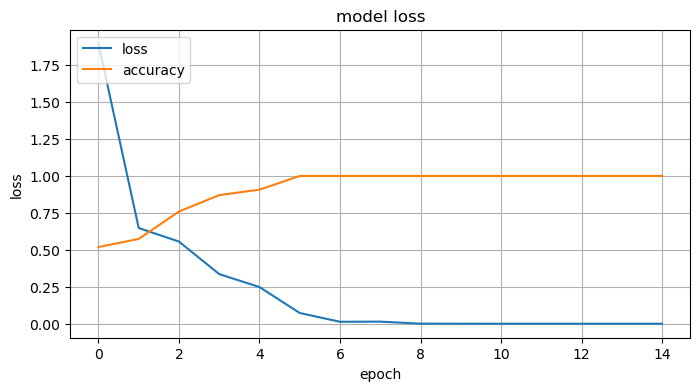

In [ ]:
# plot the training history
fig = plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"])
plt.plot(history.history["Accuracy"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "accuracy"], loc="upper left")
plt.grid()
plt.show()